# Quantum Computing 2
**Author:** Gavin DeBrun

In [ ]:
!pip3 install qiskit[visualization]

In [6]:
import qiskit
import time
from qiskit import *
import numpy as np
from qiskit.visualization import *
import pylab as plt
#from tqdm import tqdm

In [7]:
def RunMe(qc,num_shots=1024):
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc, backend,shots=num_shots)
    result = job.result()
    return result

def RunMeState(qc):
    '''Get statevector output of a circuit'''
    qcc = qc.copy()
    qcc.remove_final_measurements() #make sure we'll get a statevector
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(qcc, backend,shots=1)
    result = job.result()
    return result

def RunMeQC(qc,num_shots=1024):
    provider = IBMQ.get_provider(hub='ibm-q')
    from qiskit.providers.ibmq import least_busy
    small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                       and not x.configuration().simulator)
    #backend = least_busy(small_devices)
    backend = IBMQ.get_provider(hub='ibm-q').get_backend('ibmq_16_melbourne')
    jobReal = execute(qc, backend,shots=num_shots)
    return jobReal

def saveJob(job):
    print("jobLoad = loadJob('{}','{}')".format(job.job_id(),job.backend().name()))
def loadJob(job_id,name):
    provider = IBMQ.get_provider('ibm-q')
    thisBackend = provider.get_backend(name)
    return thisBackend.retrieve_job(job_id)

def StateToBinary(b):
    wires=int(round(np.log2(len(b))))
    for i in range(0,2**wires):
        myFormat="0"+str(wires)+"b"
        if np.abs(b[i])!=0:
            print(b[i],'|',format(i, myFormat)[::-1],'>')


In [8]:
#You should have set this up in the last notebook
IBMQ.save_account("00e972b66a800549589ee0d23c07aed4914ae87440992a8224b6fa370f9061d417aff1f96dea234eedd7ff84eaa2b547ccce2fac323079527be94803c49b39bf") #run this only once 
IBMQ.load_account()

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## Using the Speed of Quantum Computers

### a. Random Circuits

In [ ]:
def applyRandomGate(qc,wire):
    r = np.random.randint(0,3)
    if r ==0:
       #apply rx
       qc.rx(np.pi/2, wire)
    elif r==1:
       #apply ry
       qc.ry(np.pi/2, wire)
    elif r==2:
        #apply t
        qc.t(wire)
    else:
        print("Error!")

def randomCircuit(qc, nWires, nLayers):
  # apply Hadamards
  for i in range(nWires):
    qc.h(i)

  for l in range(nLayers):
      # even set of CNOT
      for i in range(0,nWires-1,2):
        qc.cx(i, i+1)
      # random single qubits
      for n in range(nWires): 
          applyRandomGate(qc,n)
      # odd set of CNOT
      for i in range(1,nWires-1,2):
        qc.cx(i, i+1)
      # random single qubits
      for n in range(nWires): 
          applyRandomGate(qc,n)
  # ending Hadamards        
  for i in range(nWires):
    qc.h(i)

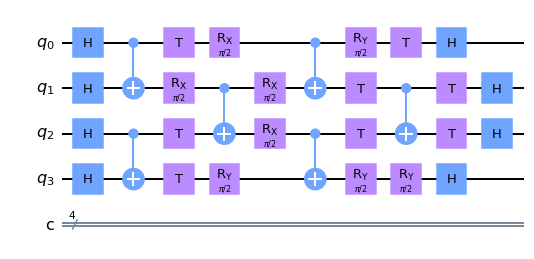

In [ ]:
nWires  = 4
nLayers = 2
D = 2**nWires
qc = QuantumCircuit(nWires,nWires)
randomCircuit(qc, nWires, nLayers)
qc.draw(output='mpl')

### b. Small Circuits

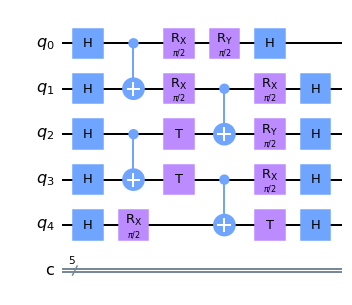

In [ ]:
#setting up circuit
nWires  = 5
nLayers = 1
D = 2**nWires
nStrings = 8192
qc = QuantumCircuit(nWires, nWires)
randomCircuit(qc,nWires, nLayers)
qc.draw(output='mpl')

In [ ]:
#Getting Exact Probabilities
results = RunMeState(qc)
state = results.get_statevector()
stateProbability = np.abs(state)**2

#Sampling Probabilities
qc.measure(range(nWires), range(nWires))
resultsSampled = RunMe(qc, nStrings)
sampledProbability = np.zeros(D)
for string,count in resultsSampled.get_counts().items(): 
    sampledProbability[int(string,2)] = (count/nStrings)

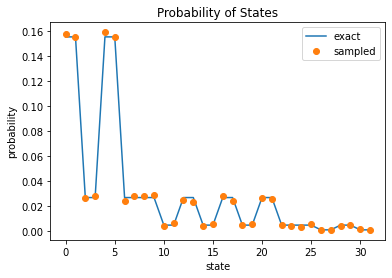

In [ ]:
#Plotting
plt.plot(stateProbability, label = "exact")
plt.plot(sampledProbability, "o", label = "sampled")
plt.legend()
plt.xlabel("state")
plt.ylabel("probability")
plt.title("Probability of States")
plt.show()

### c. On the Quantum Computer

In [ ]:
#Circuit setup
nWires = 5
D = 2**nWires
nLayers = 1
nStrings = 8192
qc = QuantumCircuit(nWires, nWires)
randomCircuit(qc, nWires, nLayers)
#qc.draw(output='mpl')

In [ ]:
#Getting Exact Probabilities
results = RunMeState(qc)
state = results.get_statevector()
stateProbability = np.abs(state)**2

#Sampling Probabilities
qc.measure(range(nWires), range(nWires))
job = RunMeQC(qc, nStrings)

In [ ]:
print(job.status())
print(job.queue_position())
saveJob(job)

JobStatus.DONE
None
jobLoad = loadJob('5fcc83d51115b9001b2ab882','ibmqx2')


In [ ]:
#job = loadJob('5fcc83d51115b9001b2ab882','ibmqx2')
resultsSampled = job.result()
sampledProbability = np.zeros(D)
for string,count in resultsSampled.get_counts().items(): 
    sampledProbability[int(string,2)] = (count/nStrings)

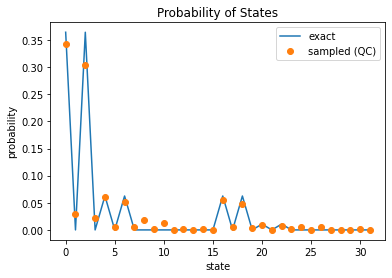

In [ ]:
#plotting
plt.plot(stateProbability, label = "exact")
plt.plot(sampledProbability, "o", label = "sampled (QC)")
plt.legend()
plt.xlabel("state")
plt.ylabel("probability")
plt.title("Probability of States")
plt.show()

## Bigger Circuits

## a. And Adding Depth

In [ ]:
#redefining to use Z-Gates

def randomCircuit(qc, nWires, nLayers):
  # apply Hadamards
  for i in range(nWires):
    qc.h(i)

  for l in range(nLayers):
      # even set of Z-Gates
      for i in range(0,nWires-1,2):
        qc.cz(i, i+1)
      # random single qubits
      for n in range(nWires): 
          applyRandomGate(qc,n)
      # odd set of Z-Gates
      for i in range(1,nWires-1,2):
        qc.cz(i, i+1)
      # random single qubits
      for n in range(nWires): 
          applyRandomGate(qc,n)
  # ending Hadamards        
  for i in range(nWires):
    qc.h(i)

In [ ]:
#Circuit setup
nWires = 14
D = 2**nWires
nLayers = 25
nStrings = 2048
qc = QuantumCircuit(nWires, nWires)
randomCircuit(qc, nWires, nLayers)

In [ ]:
#Exact Probabilities
result = RunMeState(qc)
state = result.get_statevector()
stateProbability = np.abs(state)**2

### b. Checking Convergence

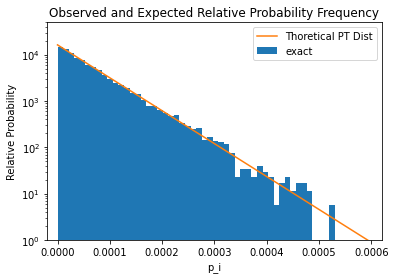

In [ ]:
plt.hist(stateProbability, bins = 50, density = True, label = "exact")

plt.yscale('log')

x = np.linspace(0,.0009,100)
y = D*np.exp(-D * x)
plt.plot(x, y, label = "Thoretical PT Dist")
plt.title("Observed and Expected Relative Probability Frequency")
plt.xlabel('p_i')
plt.ylabel('Relative Probability')
plt.legend()
plt.ylim(1, 50000)
plt.xlim(-.00002,.00062)
plt.show()

### c. Sampling Method Redux - Large Circuits

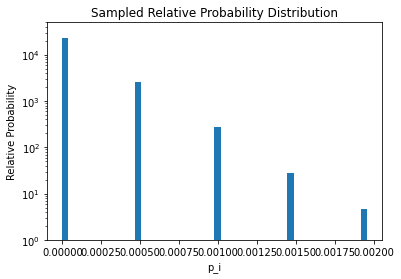

In [ ]:
qc.measure(range(nWires), range(nWires))
nStrings = 2048
resultsSampled = RunMe(qc, nStrings)
sampledProbability = np.zeros(D)
for string,count in resultsSampled.get_counts().items(): 
    sampledProbability[int(string,2)] = (count/nStrings)

plt.hist(sampledProbability, bins = 50, density = True, label = "sampled")

plt.yscale('log')
plt.xlabel("p_i")
plt.ylabel("Relative Probability")
plt.title("Sampled Relative Probability Distribution")
plt.ylim(1, 50000)
plt.show()

### d. Cross Entropy Benchmarking

In [ ]:
#generated using extra credit circuit generator (using cnots and no repeated random gates)
nWires = 14
D = 2**nWires
nLayers = 25
nStrings = 2048
qc = QuantumCircuit(nWires, nWires)
last_random_gate = np.zeros(nWires)
randomCircuit(qc, nWires, nLayers)

result = RunMeState(qc)
state = result.get_statevector()
stateProbability = np.abs(state)**2

qc.measure(range(nWires), range(nWires))
resultsSampled = RunMe(qc, nStrings)
sampled_prob = []
for string,count in resultsSampled.get_counts().items():
    loc = int(string,2)
    sampled_prob.extend([np.abs(state[loc])**2]*count)

The cross entropy is: 1.0257326691606696



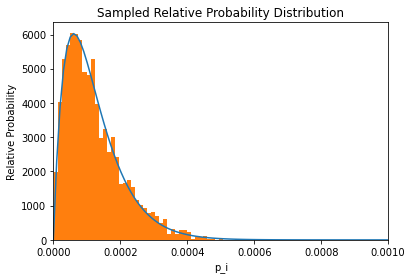

In [ ]:
F = D*sum(sampled_prob)/len(sampled_prob) - 1
print("The cross entropy is:", F)
print()
p = np.linspace(0,.001,100)
P = p*D*D*np.exp(-D*p)
plt.plot(p,P)
plt.hist(sampled_prob, bins = 50, density= True)
plt.xlim(0,.001)
plt.xlabel("p_i")
plt.ylabel("Relative Probability")
plt.title("Sampled Relative Probability Distribution")
plt.show()

In [ ]:
#extra credit part 1
def applyRandomGate(qc,wire):

  if last_random_gate[wire] == 0: #add any
    r = np.random.randint(0,3)
    if r ==0:
        #apply rx
        qc.rx(np.pi/2, wire)
        last_random_gate[wire] = 1
    elif r==1:
        #apply ry
        qc.ry(np.pi/2, wire)
        last_random_gate[wire] = 2
    elif r==2:
        #apply t
        qc.t(wire)
        last_random_gate[wire] = 3
    else:
        print("Error!")
  elif last_random_gate[wire] == 1: #only add ry or t
    r = np.random.randint(1,3)
    if r==1:
        #apply ry
        qc.ry(np.pi/2, wire)
        last_random_gate[wire] = 2
    elif r==2:
        #apply t
        qc.t(wire)
        last_random_gate[wire] = 3
    else:
        print("Error!")
  elif last_random_gate[wire] == 2: #only add rx or t
    r = np.random.randint(0,2)
    if r == 0:
      #apply rx
      qc.rx(np.pi/2, wire)
      last_random_gate[wire] = 1
    elif r == 1:
      #apply t
      qc.t(wire)
      last_random_gate[wire] = 3
  elif last_random_gate[wire] == 3: #only add rx or ry
    r = np.random.randint(0,2)
    if r == 0:
      #apply rx
      qc.rx(np.pi/2, wire)
      last_random_gate[wire] = 1
    elif r -- 1:
      #apply ry
      qc.ry(np.pi/2, wire)
      last_random_gate[wire] = 2

def randomCircuit(qc, nWires, nLayers):
  # apply Hadamards
  for i in range(nWires):
    qc.h(i)
  for l in range(nLayers):
      # even set of CNOT
      for i in range(0,nWires-1,2):
        qc.cx(i, i+1)
      # random single qubits
      for n in range(nWires):
        applyRandomGate(qc,n)
      # odd set of CNOT
      for i in range(1,nWires-1,2):
        qc.cx(i, i+1)
      # random single qubits
      for n in range(nWires):
        applyRandomGate(qc,n)
  # ending Hadamards        
  for i in range(nWires):
    qc.h(i)

In [ ]:
#extra credit part 2

job = RunMeQC(qc, nStrings)

In [ ]:
print(job.status())
print(job.queue_position())
saveJob(job)

JobStatus.DONE
None
jobLoad = loadJob('5fcff8c12eac670012c38156','ibmq_16_melbourne')


In [ ]:
resultsSampledQC = job.result()
sampled_probQC = []
for string,count in resultsSampledQC.get_counts().items():
    loc = int(string,2)
    sampled_probQC.extend([np.abs(state[loc])**2]*count)
F_QC = D*sum(sampled_probQC)/len(sampled_probQC) - 1
print("The cross entropy (fidelity) is:", F_QC)

The cross entropy (fidelity) is: 0.0017649448089265274


In [11]:
import qiskit.tools.jupyter
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends.ibmq_16_melbourne

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>